In [176]:
#  !pip install sidetable
#  !pip install tabulate

In [177]:
import pandas as pd;import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sidetable as stb

from IPython.display import HTML, display
import tabulate
import re
%matplotlib inline

## Read the data to Pandas Data Frame

In [178]:
df = pd.read_csv("https://raw.githubusercontent.com/psiva2019/Hackathon/master/Algoritmo/Data/Train_Set.csv",error_bad_lines=False)
df_test = pd.read_csv("https://raw.githubusercontent.com/psiva2019/Hackathon/master/Algoritmo/Data/Test_Set.csv",error_bad_lines=False)
df.head(10)

,OrderId,Customer_Id,Customer_Category,Cust_State,Zipcode,Sales,Order_zone,Price,CategoryName,Transcation,...,ProductLength,ProductWeight,Dispatched,Shipping_Class,Scheduled_Shipping,Warehouse_Region,Delivery_Review,Session_Ordered,WeekdayOrder,Delivery_Status
0,2477882,12386,Consumer,AR,19120,150.0,Central,4383.39,Cat-2,UPI,...,191.0,1592.0,0,Standard,4,NORTH,5.0,2.0,0,0
1,2477895,2630,Consumer,BR,2907,165.0,East,4295.72,Cat-2,UPI,...,79.0,1420.0,0,Standard,6,NORTH,2.0,2.0,1,0
2,2473260,1752,Corporate,RJ,90214,171.0,South,3616.65,Cat-50,Cash,...,67.0,1231.0,0,Standard,6,SOUTH,4.0,2.0,0,1
3,2466916,9268,Consumer,UP,745,132.0,East,9175.86,Cat-12,Credit,...,45.0,NaN,1,2A,4,NORTH,4.0,3.0,1,1
4,2351480,2888,Corporate,UP,92427,NaN,North,2779.29,Cat-3,UPI,...,43.0,1018.0,1,Standard,5,CENTRAL,2.0,1.0,0,1
5,2505273,5971,others,UP,10470,144.0,Central,4226.54,Cat-2,Debit,...,48.0,271.0,1,Standard,5,CENTRAL,4.0,3.0,1,1
6,2374621,4228,others,JK,20799,160.0,North,2787.77,Cat-42,Debit,...,195.0,1417.0,1,Elite,4,SOUTH,4.0,3.0,0,0
7,2402171,12250,Corporate,UP,77113,202.0,Central,21374.50,Cat-13,Debit,...,173.0,16563.0,1,Standard,6,NORTH,3.0,1.0,1,1
8,2497815,9012,Consumer,BR,743,373.0,Central,28399.01,Cat-32,UPI,...,104.0,3493.0,1,1A,2,NORTH,3.0,2.0,1,1
9,2477174,6134,Consumer,MA,97221,112.0,West,2979.73,Cat-3,UPI,...,30.0,655.0,0,Standard,3,SOUTH,4.0,1.0,0,0


## Data Report

In [179]:
#Shape of the Data
print('****Shape of the hotel data****')
print('********************************')
print('No of rows\t:\t{}\nNo of columns\t:\t{}'.format(df.shape[0],df.shape[1]))

****Shape of the hotel data****
********************************
No of rows	:	126363
No of columns	:	28


In [180]:
print('****Show infomation of the train data****')
print('***********************************')
df.info()

****Show infomation of the train data****
***********************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126363 entries, 0 to 126362
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   OrderId             126363 non-null  int64  
 1   Customer_Id         126363 non-null  int64  
 2   Customer_Category   126363 non-null  object 
 3   Cust_State          126363 non-null  object 
 4   Zipcode             126363 non-null  int64  
 5   Sales               122749 non-null  float64
 6   Order_zone          126363 non-null  object 
 7   Price               126363 non-null  float64
 8   CategoryName        126363 non-null  object 
 9   Transcation         126363 non-null  object 
 10  Dept_Id             126363 non-null  int64  
 11  Dept_Name           126363 non-null  object 
 12  Profit_Ratio        126363 non-null  float64
 13  Discount            121313 non-null  float64
 14  Quanti

In [181]:
#Check for duplicate values
print('****Duplicates data in the train dataset without EmployeeID Column****')
print('**********************************************************************')

dups = df.loc[:, ~df.columns. isin(['EmployeeID'])].duplicated().sum()
if dups ==0:
    print('There is no duplicate values in the data.') 
else:
    print('There are {} duplicates in the data which is {}% of total data'.format(dups,round((dups/df.shape[0])*100,2)))

****Duplicates data in the train dataset without EmployeeID Column****
**********************************************************************
There is no duplicate values in the data.


In [182]:
#Check for missing value
print('****Missing Values in the Dataset****')
print('*************************************')
msv = df.isnull().sum()[df.isnull().sum()>0]
if msv.empty:
    print('There is no missing values in the data.') 
else:
    for i in range(msv.count()):
        print('{} Missing values in {} which is {}% of total data ({})'.format(msv[i],msv.index[i],round(((msv[i]/df.shape[0])*100),2),df[msv.index[i]].dtype))

****Missing Values in the Dataset****
*************************************
3614 Missing values in Sales which is 2.86% of total data (float64)
5050 Missing values in Discount which is 4.0% of total data (float64)
2946 Missing values in ProductLength which is 2.33% of total data (float64)
695 Missing values in ProductWeight which is 0.55% of total data (float64)
9065 Missing values in Delivery_Review which is 7.17% of total data (float64)
4792 Missing values in Session_Ordered which is 3.79% of total data (float64)


In [183]:
#Check for missing value
print('****Missing Values in the Dataset****')
print('*************************************')
msv = df_test.isnull().sum()[df_test.isnull().sum()>0]
if msv.empty:
    print('There is no missing values in the data.') 
else:
    for i in range(msv.count()):
        print('{} Missing values in {} which is {}% of total data ({})'.format(msv[i],msv.index[i],round(((msv[i]/df_test.shape[0])*100),2),df_test[msv.index[i]].dtype))

****Missing Values in the Dataset****
*************************************
1460 Missing values in Sales which is 2.7% of total data (float64)
2174 Missing values in Discount which is 4.01% of total data (float64)
1304 Missing values in ProductLength which is 2.41% of total data (float64)
307 Missing values in ProductWeight which is 0.57% of total data (float64)
3896 Missing values in Delivery_Review which is 7.19% of total data (float64)
2031 Missing values in Session_Ordered which is 3.75% of total data (float64)


In [184]:
def display_dataframe(df,dtypeval):
    numeric_col_mask = df.dtypes.apply(lambda d: issubclass(np.dtype(d).type, dtypeval))

    # Dict used to center the table headers
    d = dict(selector="th",
        props=[('text-align', 'left')])

    # Style
    display(df.style.set_properties(subset=df.columns[numeric_col_mask], 
                            **{'width':'15em', 'height':'3em','text-align':'left','border-color':'White','border-width':'thin'})\
            .set_properties(subset=df.columns[~numeric_col_mask], 
                            **{'width':'15em', 'text-align':'left','border-color':'White','border-width':'thin'})\
            .format(lambda x: '{:,.0f}'.format(x) if x > 1e3 else '{:,.2f}'.format(x), # format the numeric values
                    subset=pd.IndexSlice[:,df.columns[numeric_col_mask]])\
            .hide_index()\

#            .highlight_max('color: green')\
            .set_table_styles([d])) # center the header

In [185]:
cvar = ['Dept_Id','Dispatched','Scheduled_Shipping','Delivery_Review','Session_Ordered','WeekdayOrder']
for var in cvar:
    df[var] = df[var].astype('object')
    df_test[var] = df_test[var].astype('object')

In [186]:
for var in df.columns:
  if(df[var].dtype=='object'):
    print(f'**** Unique Counts of {var}****')
    print(df[var].value_counts())
    print('\n')

**** Unique Counts of Customer_Category****
Consumer     65464
Corporate    38360
others       22539
Name: Customer_Category, dtype: int64


**** Unique Counts of Cust_State****
AR     7105
RJ     7104
MP     7077
JK     7072
AP     7065
PB     7046
MA     7041
HP     7032
HR     7027
OR     7023
BR     7020
TEL    7000
KL     6980
GJ     6979
UP     6978
KA     6974
WB     6945
UK     6895
Name: Cust_State, dtype: int64


**** Unique Counts of Order_zone****
North      25375
South      25327
East       25257
Central    25230
West       25174
Name: Order_zone, dtype: int64


**** Unique Counts of CategoryName****
Cat-2     17297
Cat-12    15489
Cat-4     14762
Cat-50    13551
Cat-32    12223
Cat-49    10810
Cat-13     9564
Cat-7      8735
Cat-3      7593
Cat-5      2203
Cat-20     1232
Cat-27     1016
Cat-19      854
Cat-42      799
Cat-8       667
Cat-41      609
Cat-11      458
Cat-21      448
Cat-29      447
Cat-37      418
Cat-15      405
Cat-48      375
Cat-44      365
Cat-22     

In [187]:
cvar = ['Sales','Discount','ProductLength','ProductWeight']
for var in cvar:
  df[var].fillna(df[var].median(),inplace=True)
  df_test[var].fillna(df_test[var].median(),inplace=True)

cvar = ['Delivery_Review','Session_Ordered']
for var in cvar:
  df[var].fillna(df[var].mode()[0],inplace=True)
  df_test[var].fillna(df_test[var].mode()[0],inplace=True)

In [188]:
#Check for missing value
print('****Missing Values in the Dataset****')
print('*************************************')
msv = df.isnull().sum()[df.isnull().sum()>0]
if msv.empty:
    print('There is no missing values in the data.') 
else:
    for i in range(msv.count()):
        print('{} Missing values in {} which is {}% of total data ({})'.format(msv[i],msv.index[i],round(((msv[i]/df.shape[0])*100),2),df[msv.index[i]].dtype))

****Missing Values in the Dataset****
*************************************
There is no missing values in the data.


In [189]:
def unq_count_new(df,var,top_val,tit,dpn):
    #var='meal'

    if(top_val == 0):
        perclass = pd.DataFrame(df[var].value_counts(normalize=True,dropna=dpn))
        tardisval = pd.DataFrame(df[var].value_counts(dropna=dpn))
    else:
        perclass = pd.DataFrame(df[var].value_counts(normalize=True,dropna=dpn)[df[var].value_counts(dropna=dpn)>top_val])
        tardisval = pd.DataFrame(df[var].value_counts(dropna=dpn)[df[var].value_counts(dropna=dpn)>top_val])
        
    disdf = pd.concat([tardisval,round(perclass*100,3)],axis=1)
    disdf.reset_index()
    disdf.columns=['Count','Percent']

    str1 = f'**** Unique value distribution of {tit.title()} ******'

    width = len(str1)
    filler = '*'

    print(str1)
    print(f'{"*" :{filler}>{width}}\n')

    print(tabulate.tabulate(disdf, tablefmt='fancy_grid',headers=[tit.title(),'Count','Percent']))
    #return (disdf)

In [190]:
# dff=df
# typevar='char'
# var='coupon_used_for_payment'
# tar='Churn'
# tit='coupon_used_for_payment'

# textlab='# of Customers'
# textlab_tar='# of Churn Customers'


# result = dff.groupby([var])[tar].aggregate(np.sum).reset_index().sort_values(tar,ascending = False)
# #print(result[result[tar]>0])
# result = result[result[tar]>0]
# b = sns.barplot(data=result, y=var,x=tar,orient='h',order=result[var])


# b.set_frame_on(False)

# b.set_ylabel('')
# #b.set_ylabel(var,weight='bold')
# b.set_xlabel(textlab_tar,weight='bold')

# b.set_xticklabels([])
# b.tick_params(bottom=False)
# b.set_yticklabels(list(result[var].value_counts().index),weight='bold')
# #b.set_yticklabels([])
# maxwidth = dff[var].value_counts().max()
# for p in b.patches:
#     width = np.nan_to_num(p.get_width()) 
#     wdplace = width
#     per = (width/dff.shape[0])*100
#     wdplace = wdplace + maxwidth * 1/100
    
#     b.text(wdplace,
#         p.get_y()+.5,
#         '{} - ({:1.2f}%)'.format(round(width),(width/dff.shape[0])*100),
#         ha="center",weight='bold') 

In [191]:
# dff=df
# typevar='char'
# var='coupon_used_for_payment'
# tar='Churn'
# tit='coupon_used_for_payment'

# textlab='# of Customers'
# textlab_tar='# of Churn Customers'

# fig, axis=plt.subplots(nrows=1,ncols=2)
# fig.set_size_inches(15,4)

# a = sns.countplot(data=dff, y=var,ax=axis[0],order=dff[var].value_counts().index)

# a.set_frame_on(False)

# #a.set_ylabel(var,weight='bold')
# a.set_ylabel('')
# a.set_xlabel(textlab,weight='bold')


# a.set_xticklabels([])
# a.tick_params(bottom=False)
# a.set_yticklabels(list(dff[var].value_counts().index),weight='bold')

# maxwidth = dff[var].value_counts().max()

# for p in a.patches:
#     width = np.nan_to_num(p.get_width()) 
#     wdplace = width
#     per = (width/dff.shape[0])*100
#     #print(width)
#     wdplace = wdplace + maxwidth * 10/100
#     # if(per < 1):
#     #     wdplace = wdplace + maxwidth * 10/100
#     # else:
#     #     wdplace = wdplace - maxwidth * 10/100
    
#     a.text(wdplace,
#         p.get_y()+.5,
#         '{} - ({:1.2f}%)'.format(round(width),per),
#         ha="center",weight='bold') 

### Univarient Analsyis

In [192]:
def display_unq(dff,var,tar,bins,typevar,tit,textlab,textlab_tar,iwidth,iheight):
  if(typevar=='num'):
    fig, axis=plt.subplots(nrows=1,ncols=3)
    fig.set_size_inches(iwidth,iheight)

    str1 = f'**** {tit.title()} ****'

    width = len(str1)
    filler = '*'

    print(str1)
    print(f'{"*" :{filler}>{width}}\n')

    dff_r = pd.DataFrame(round(dff[var].describe(),2)).T
    print(tabulate.tabulate(dff_r, tablefmt='fancy_grid',headers=dff_r.columns))
    
    str2 = f'\n**** Visuallations of Feature {tit.title()} ****'

    width = len(str2)
    filler = '*'

    print(str2)
    print(f'{"*" :{filler}>{width}}\n')

    a= sns.histplot(dff[var],ax=axis[0],bins=bins);
    b= sns.boxplot(dff[var],ax=axis[1]);
    c= sns.kdeplot(dff[var],ax=axis[2],hue=df[tar])

    a.set_xlabel('')
    b.set_xlabel('')
    c.set_xlabel('')
    a.set_ylabel('')
    c.set_ylabel('')

    a.set_frame_on(False)
    b.set_frame_on(False)
    c.set_frame_on(False)

  else:
    fig, axis=plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(iwidth,iheight)

    #unq_count_new(dff,var,0,tit,True)

    str2 = f'\n**** Visuallations of Feature {tit.title()} ****'

    width = len(str2)
    filler = '*'

    print(str2)
    print(f'{"*" :{filler}>{width}}\n')

    a = sns.countplot(data=dff, y=var,ax=axis[0],order=dff[var].value_counts().index)

    a.set_frame_on(False)

    #a.set_ylabel(var,weight='bold')
    a.set_ylabel('')
    a.set_xlabel(textlab,weight='bold')


    a.set_xticklabels([])
    a.tick_params(bottom=False)
    a.set_yticklabels(list(dff[var].value_counts().index),weight='bold')

    for p in a.patches:
        width = np.nan_to_num(p.get_width()) 
        width_1 = width
        per = (width/dff.shape[0])*100
        #print(width,p.get_y(),per)

        if(per < 1):
            width = width + 750
        else:
            width = width + 220
        
        a.text(width,
            p.get_y()+.5,
            '{} - ({:1.2f}%)'.format(width_1,(width_1/dff.shape[0])*100),
            ha="center",weight='bold') 
    
    result = dff.groupby([var])[tar].aggregate(np.sum).reset_index().sort_values(tar,ascending = False)
    result = result[result[tar]>0]
    b = sns.barplot(data=result, y=var,x=tar,orient='h',order=result[var],ax=axis[1])

    b.set_frame_on(False)

    b.set_ylabel('')
    #b.set_ylabel(var,weight='bold')
    b.set_xlabel(textlab_tar,weight='bold')

    b.set_xticklabels([])
    b.tick_params(bottom=False)
    b.set_yticklabels(list(result[var].value_counts().index),weight='bold')
    b.set_yticklabels([])

    for p in b.patches:
        width = np.nan_to_num(p.get_width()) 
        width_1 = width
        per = (width/dff.shape[0])*100
        #print(width,p.get_y(),per)

        if(per < 1):
            width = width + 750
        else:
            width = width + 20
        
        b.text(width,
            p.get_y()+.5,
            '{} - ({:1.2f}%)'.format(width_1,(width_1/dff.shape[0])*100),
            ha="center",weight='bold') 



**** Visuallations of Feature Customer Category ****
*****************************************************



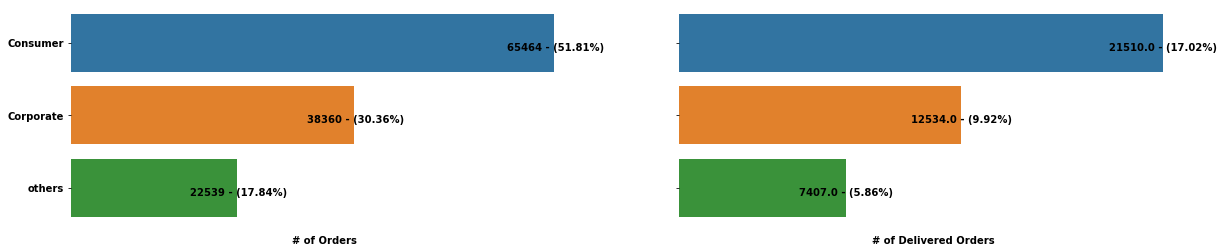

In [193]:
textlab='# of Orders'
textlab_tar='# of Delivered Orders'

display_unq(df,'Customer_Category','Delivery_Status',10,'chars','Customer Category',textlab,textlab_tar,20,4)


**** Visuallations of Feature Customer State ****
**************************************************



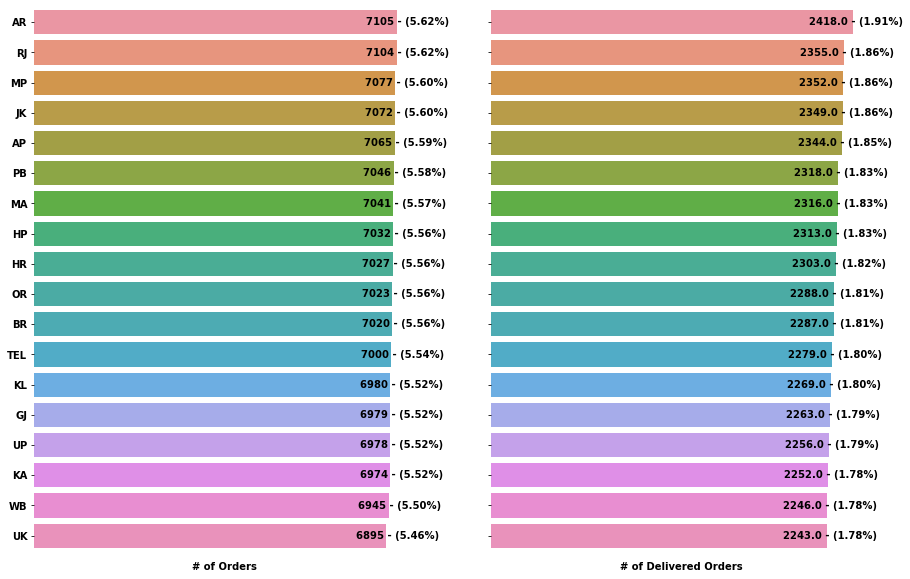

In [194]:
display_unq(df,'Cust_State','Delivery_Status',10,'chars','Customer State',textlab,textlab_tar,15,10)


**** Visuallations of Feature Order Zone ****
**********************************************



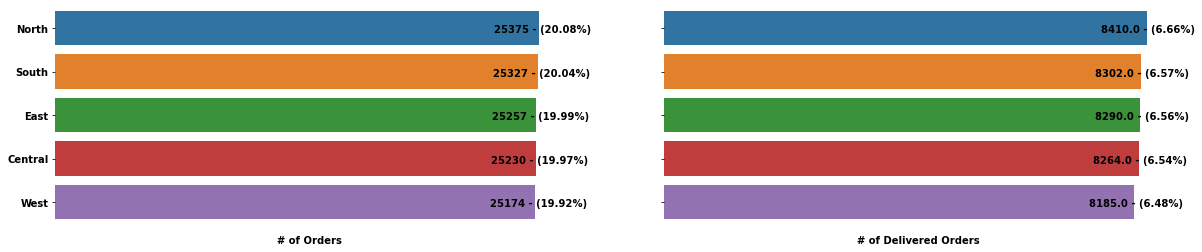

In [195]:
display_unq(df,'Order_zone','Delivery_Status',10,'chars','Order zone',textlab,textlab_tar,20,4)


**** Visuallations of Feature Category Name ****
*************************************************



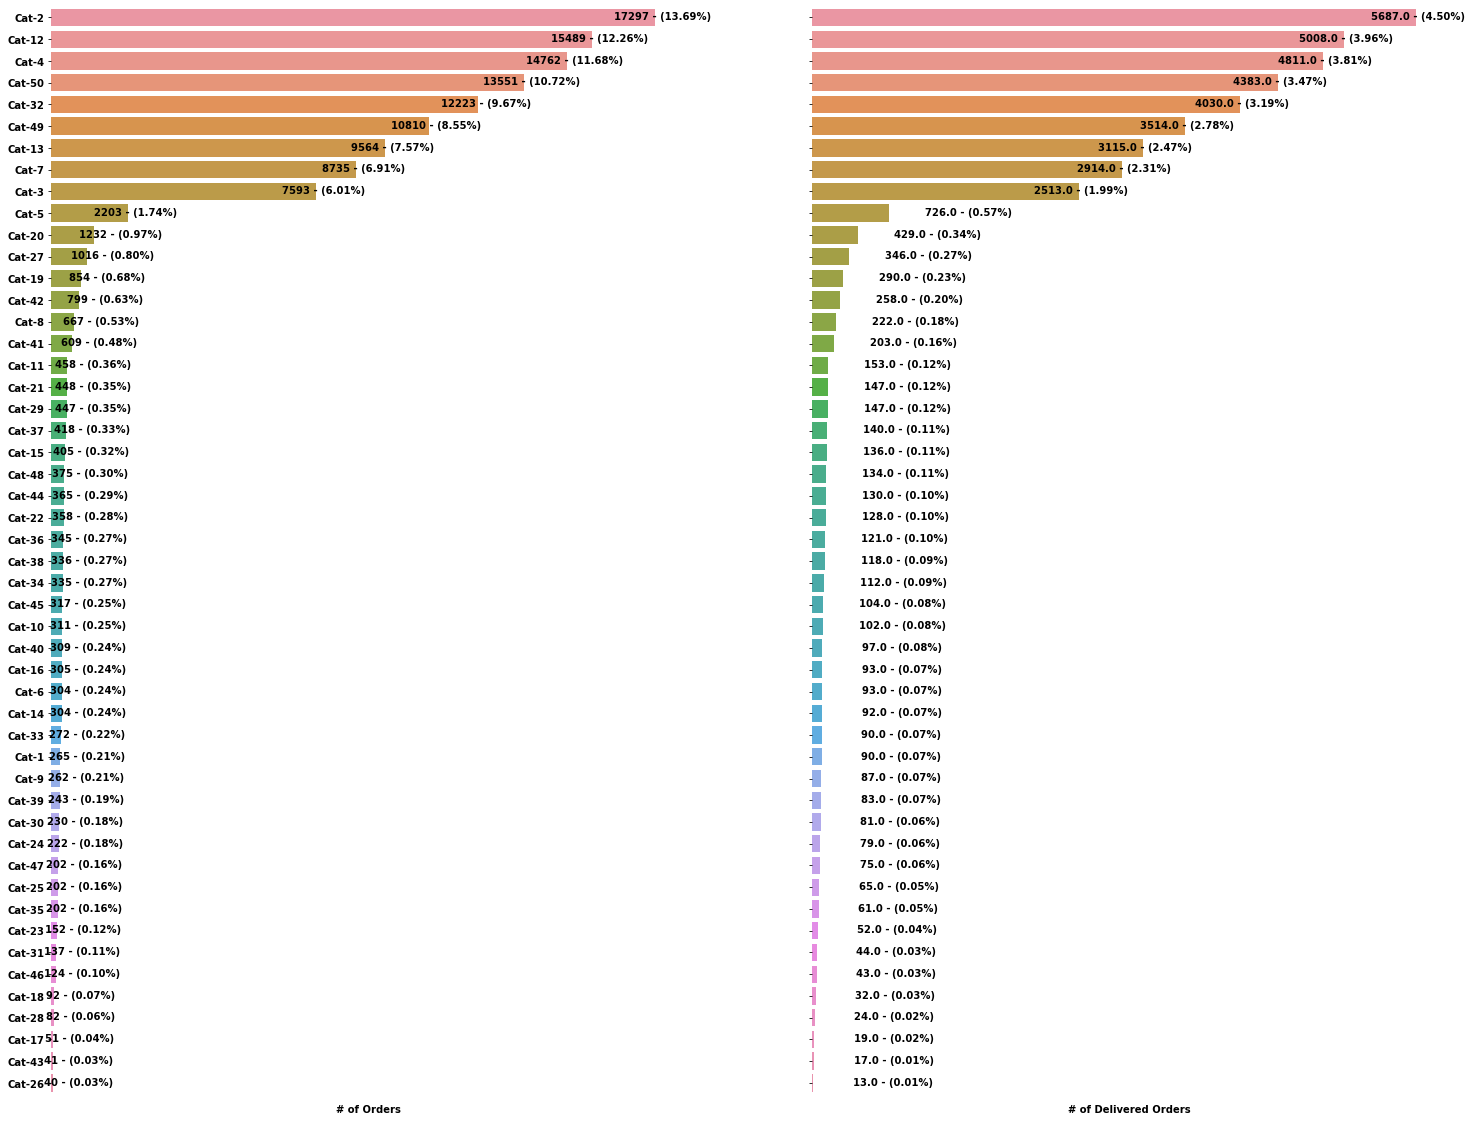

In [196]:
display_unq(df,'CategoryName','Delivery_Status',10,'chars','Category Name',textlab,textlab_tar,25,20)


**** Visuallations of Feature Transcation ****
***********************************************



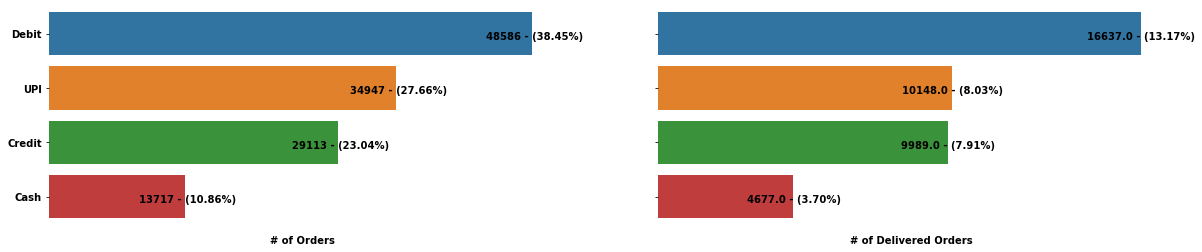

In [197]:
display_unq(df,'Transcation','Delivery_Status',10,'chars','Transcation',textlab,textlab_tar,20,4)


**** Visuallations of Feature Dept Name ****
*********************************************



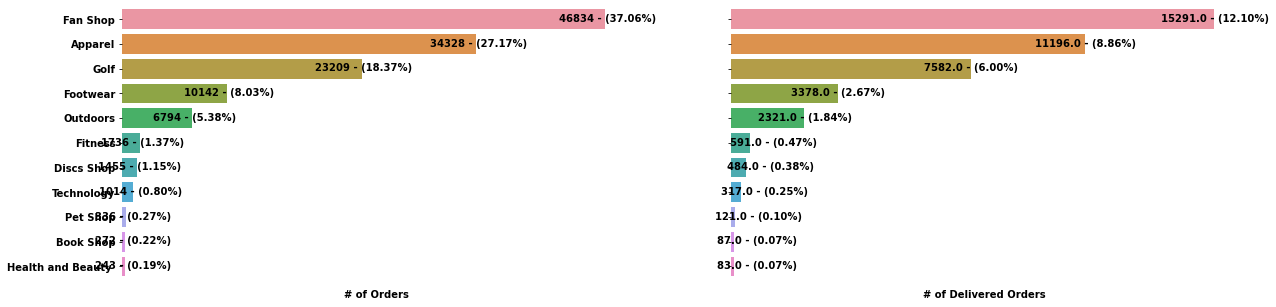

In [198]:
display_unq(df,'Dept_Name','Delivery_Status',10,'chars','Dept Name',textlab,textlab_tar,20,5)


**** Visuallations of Feature Dispatched ****
**********************************************



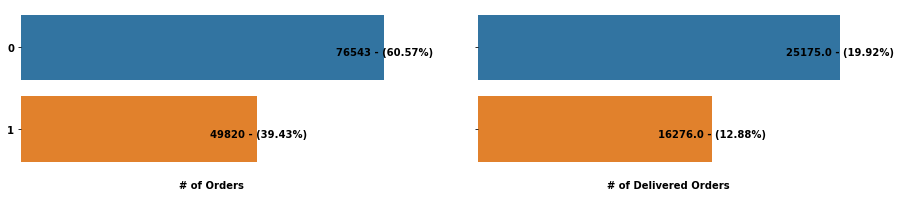

In [199]:
display_unq(df,'Dispatched','Delivery_Status',10,'chars','Dispatched',textlab,textlab_tar,15,3)


**** Visuallations of Feature Shipping Class ****
**************************************************



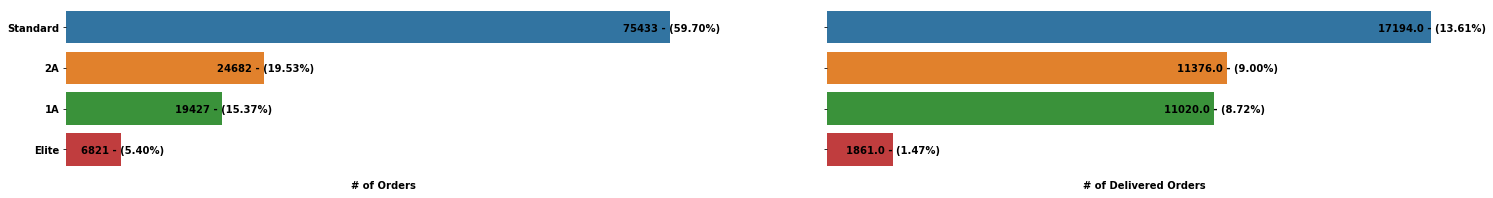

In [200]:
display_unq(df,'Shipping_Class','Delivery_Status',10,'chars','Shipping Class',textlab,textlab_tar,25,3)


**** Visuallations of Feature Scheduled Shipping ****
******************************************************



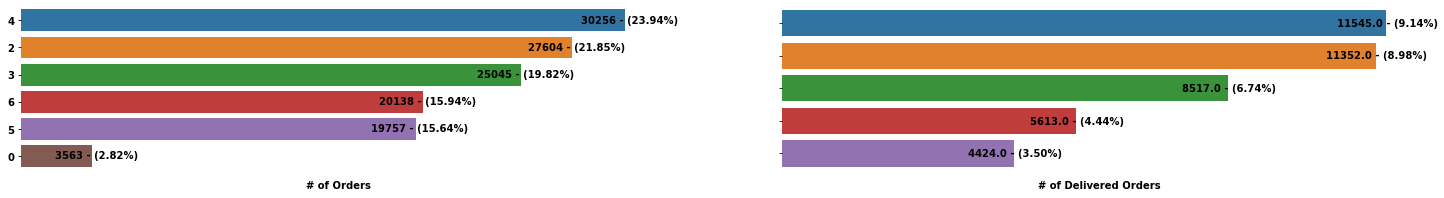

In [201]:
display_unq(df,'Scheduled_Shipping','Delivery_Status',10,'chars','Scheduled Shipping',textlab,textlab_tar,25,3)


**** Visuallations of Feature Warehouse Region ****
****************************************************



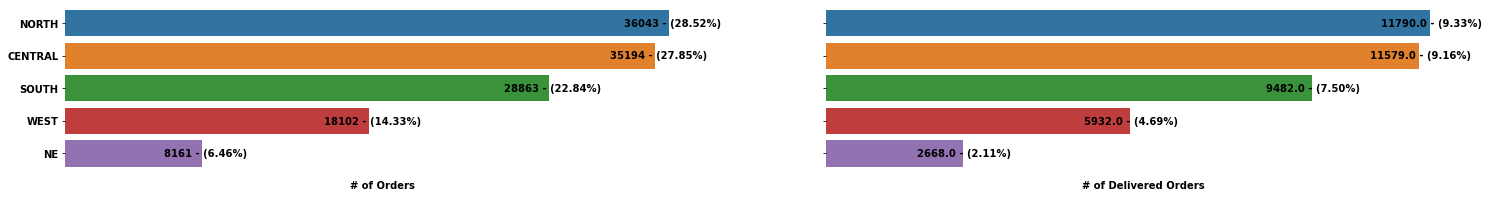

In [202]:
display_unq(df,'Warehouse_Region','Delivery_Status',10,'chars','Warehouse Region',textlab,textlab_tar,25,3)


**** Visuallations of Feature Delivery Review ****
***************************************************



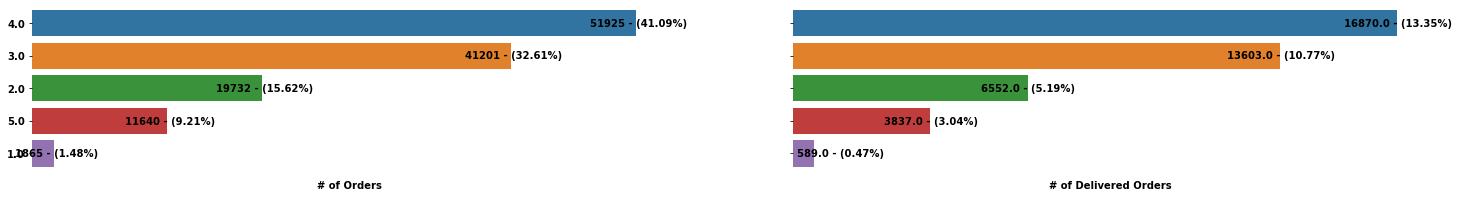

In [203]:
display_unq(df,'Delivery_Review','Delivery_Status',10,'chars','Delivery Review',textlab,textlab_tar,25,3)


**** Visuallations of Feature Session Ordered ****
***************************************************



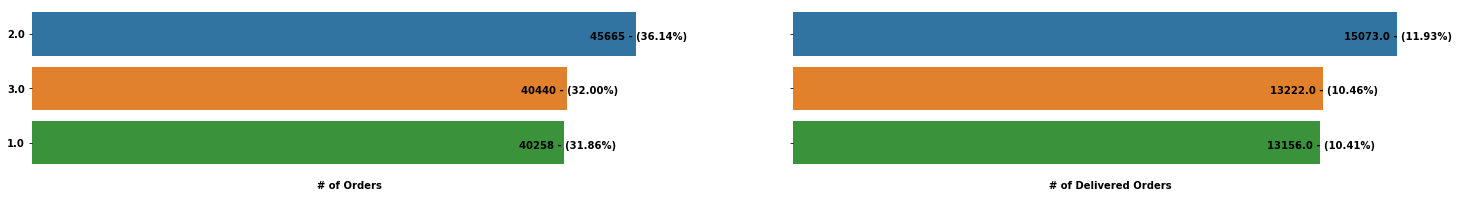

In [204]:
display_unq(df,'Session_Ordered','Delivery_Status',10,'chars','Session Ordered',textlab,textlab_tar,25,3)


**** Visuallations of Feature Weekday Order ****
*************************************************



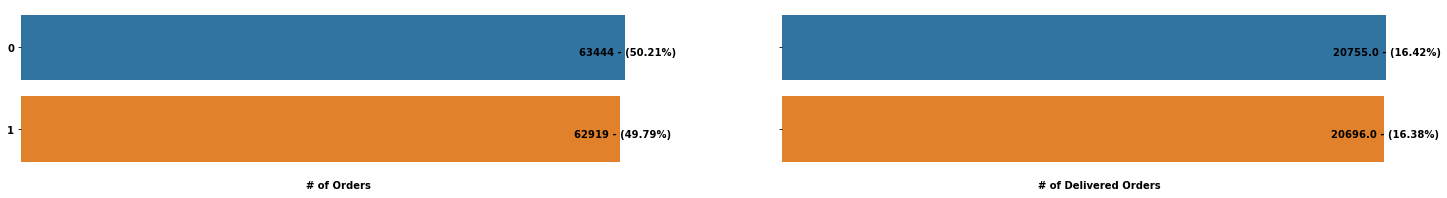

In [205]:
display_unq(df,'WeekdayOrder','Delivery_Status',10,'chars','Weekday Order',textlab,textlab_tar,25,3)


**** Visuallations of Feature Product_Type ****
************************************************



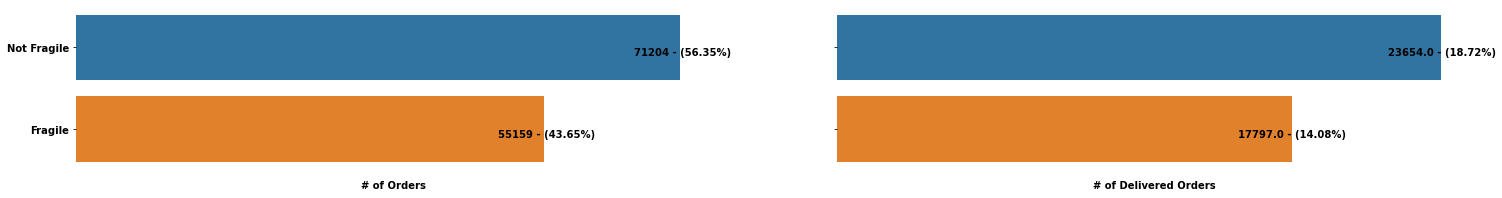

In [206]:
display_unq(df,'Product_type','Delivery_Status',10,'chars','Product_type',textlab,textlab_tar,25,3)

**** Sales ****
***************

╒═══════╤═════════╤════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│       │   count │   mean │    std │   min │   25% │   50% │   75% │   max │
╞═══════╪═════════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ Sales │  126363 │ 195.46 │ 119.76 │    28 │   114 │   173 │   257 │  1969 │
╘═══════╧═════════╧════════╧════════╧═══════╧═══════╧═══════╧═══════╧═══════╛

**** Visuallations of Feature Sales ****
*****************************************



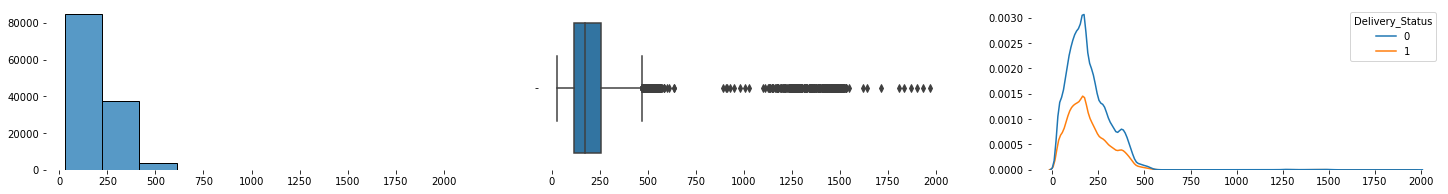

In [207]:
display_unq(df,'Sales','Delivery_Status',10,'num','Sales',textlab,textlab_tar,25,3)

**** Price ****
***************

╒═══════╤═════════╤═════════╤═════════╤════════╤═════════╤═════════╤═════════╤════════╕
│       │   count │    mean │     std │    min │     25% │     50% │     75% │    max │
╞═══════╪═════════╪═════════╪═════════╪════════╪═════════╪═════════╪═════════╪════════╡
│ Price │  126363 │ 10064.8 │ 9923.79 │ 617.31 │ 3587.76 │ 4415.28 │ 14222.4 │ 142151 │
╘═══════╧═════════╧═════════╧═════════╧════════╧═════════╧═════════╧═════════╧════════╛

**** Visuallations of Feature Price ****
*****************************************



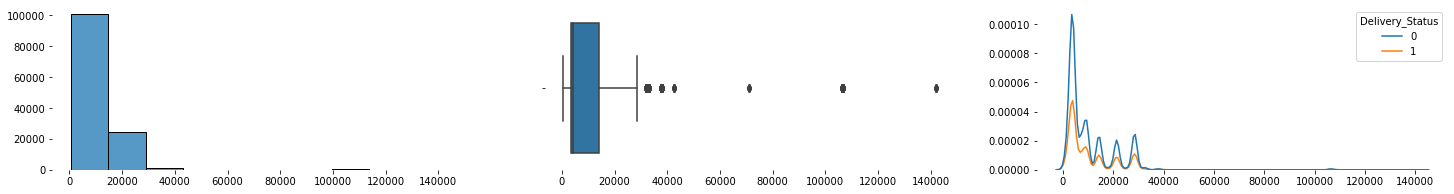

In [208]:
display_unq(df,'Price','Delivery_Status',10,'num','Price',textlab,textlab_tar,25,3)

**** Profit Ratio ****
**********************

╒══════════════╤═════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│              │   count │   mean │   std │   min │   25% │   50% │   75% │   max │
╞══════════════╪═════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ Profit_Ratio │  126363 │   0.12 │  0.47 │ -2.75 │  0.08 │  0.28 │  0.37 │   0.5 │
╘══════════════╧═════════╧════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╛

**** Visuallations of Feature Profit Ratio ****
************************************************



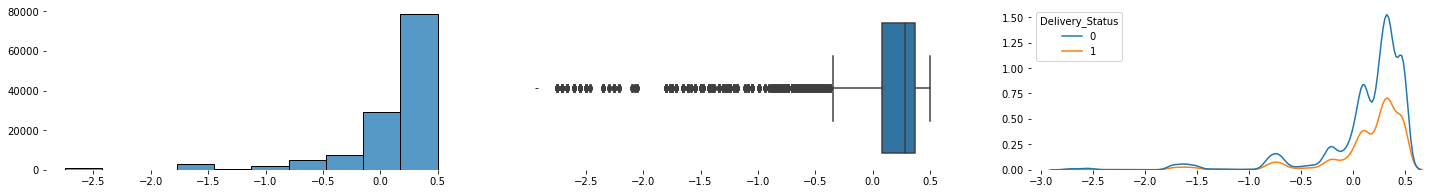

In [209]:
display_unq(df,'Profit_Ratio','Delivery_Status',10,'num','Profit Ratio',textlab,textlab_tar,25,3)

**** Discount ****
******************

╒══════════╤═════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│          │   count │   mean │   std │   min │   25% │   50% │   75% │   max │
╞══════════╪═════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ Discount │  126363 │   0.11 │  0.07 │     0 │  0.04 │   0.1 │  0.16 │  0.25 │
╘══════════╧═════════╧════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╛

**** Visuallations of Feature Discount ****
********************************************



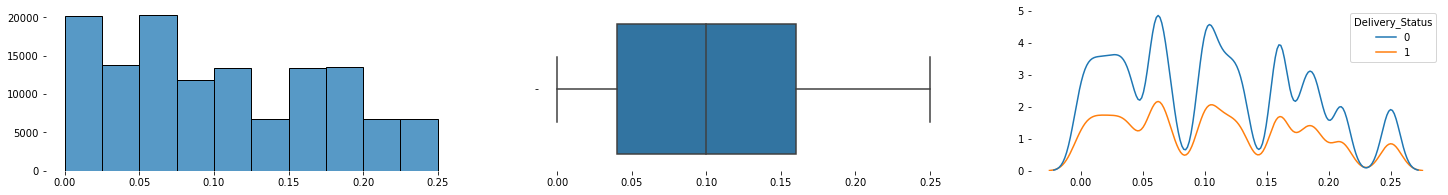

In [210]:
display_unq(df,'Discount','Delivery_Status',10,'num','Discount',textlab,textlab_tar,25,3)

**** Quantity ****
******************

╒══════════╤═════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│          │   count │   mean │   std │   min │   25% │   50% │   75% │   max │
╞══════════╪═════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ Quantity │  126363 │   2.13 │  1.45 │     1 │     1 │     1 │     3 │     5 │
╘══════════╧═════════╧════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╛

**** Visuallations of Feature Quantity ****
********************************************



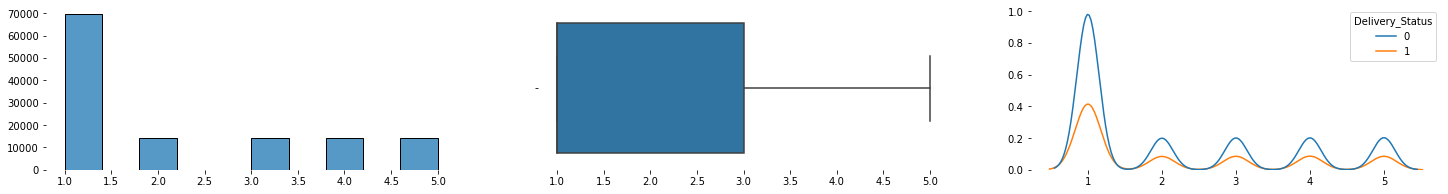

In [211]:
display_unq(df,'Quantity','Delivery_Status',10,'num','Quantity',textlab,textlab_tar,25,3)

**** Order Profit  ****
***********************

╒══════════════╤═════════╤═════════╤═════════╤═════════╤════════╤═════════╤════════╤═════════╕
│              │   count │    mean │     std │     min │    25% │     50% │    75% │     max │
╞══════════════╪═════════╪═════════╪═════════╪═════════╪════════╪═════════╪════════╪═════════╡
│ Order_Profit │  126363 │ 1257.02 │ 6690.79 │ -271606 │ 314.08 │ 1258.74 │ 3119.9 │ 68156.7 │
╘══════════════╧═════════╧═════════╧═════════╧═════════╧════════╧═════════╧════════╧═════════╛

**** Visuallations of Feature Order Profit  ****
*************************************************



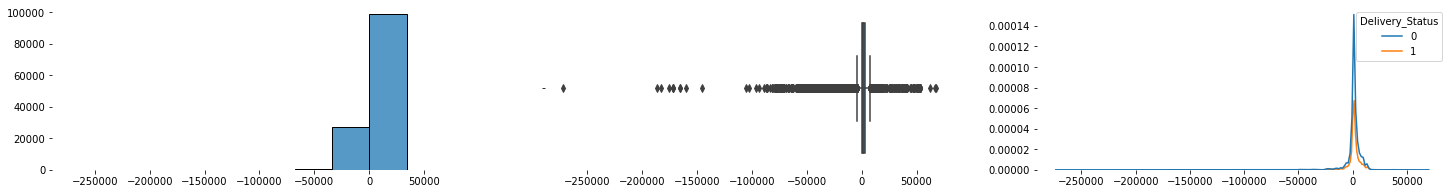

In [212]:
display_unq(df,'Order_Profit ','Delivery_Status',10,'num','Order Profit ',textlab,textlab_tar,25,3)

**** Product Length ****
************************

╒═══════════════╤═════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│               │   count │   mean │   std │   min │   25% │   50% │   75% │   max │
╞═══════════════╪═════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ ProductLength │  126363 │   95.7 │ 54.74 │    10 │    52 │    84 │   139 │   210 │
╘═══════════════╧═════════╧════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╛

**** Visuallations of Feature Product Length ****
**************************************************



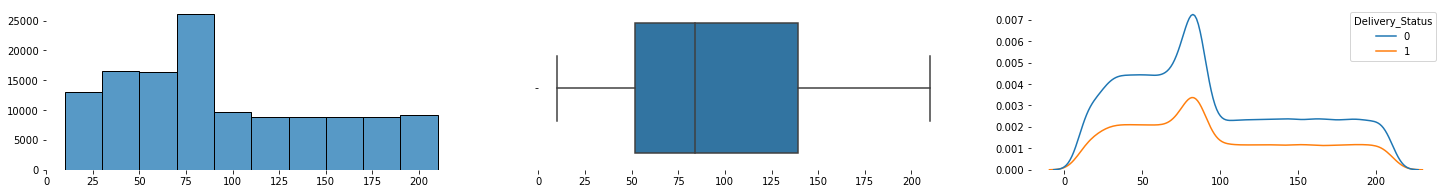

In [213]:
display_unq(df,'ProductLength','Delivery_Status',10,'num','Product Length',textlab,textlab_tar,25,3)

**** Product Weight ****
************************

╒═══════════════╤═════════╤═════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│               │   count │    mean │     std │   min │   25% │   50% │   75% │   max │
╞═══════════════╪═════════╪═════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ ProductWeight │  126363 │ 3736.04 │ 7600.45 │    10 │   764 │  1640 │  2706 │ 43999 │
╘═══════════════╧═════════╧═════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╛

**** Visuallations of Feature Product Weight ****
**************************************************



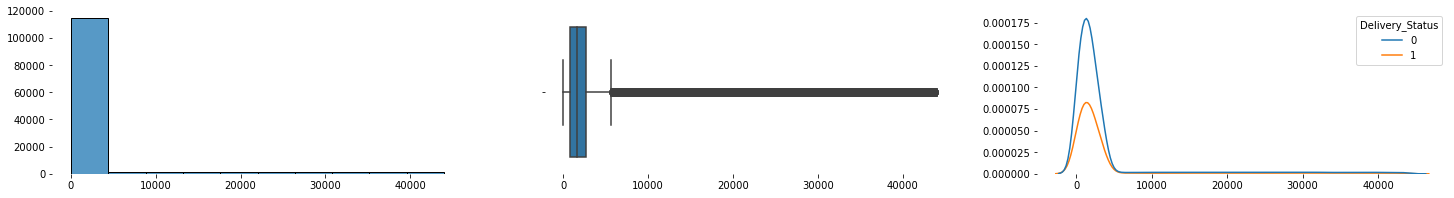

In [214]:
display_unq(df,'ProductWeight','Delivery_Status',10,'num','Product Weight',textlab,textlab_tar,25,3)

In [215]:
cols = ['Dept_Id','Dispatched','Scheduled_Shipping','WeekdayOrder']
for var in cols:
    df[var] = df[var].astype('int')

In [216]:
#Define the function to identify the outliers
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [217]:
columns = ['Sales','Price','Profit_Ratio','ProductWeight','Order_Profit ']
#Fix the outliers 
for column in df[columns].columns:
    lr,ur=remove_outlier(df[column])
    df[column]=np.where(df[column]>ur,ur,df[column])
    df[column]=np.where(df[column]<lr,lr,df[column])
    
    df_test[column]=np.where(df_test[column]>ur,ur,df_test[column])
    df_test[column]=np.where(df_test[column]<lr,lr,df_test[column])

<AxesSubplot:>

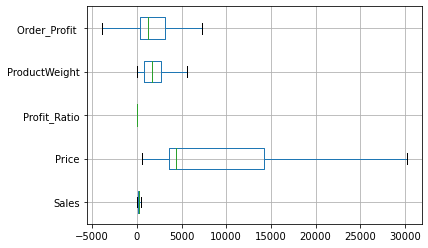

In [218]:
columns = ['Sales','Price','Profit_Ratio','ProductWeight','Order_Profit ']

df[columns].boxplot(vert=False)

<AxesSubplot:>

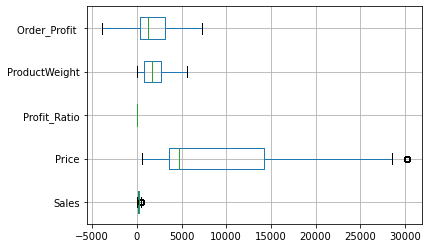

In [219]:
df_test[columns].boxplot(vert=False)

In [220]:
#!pip install dython

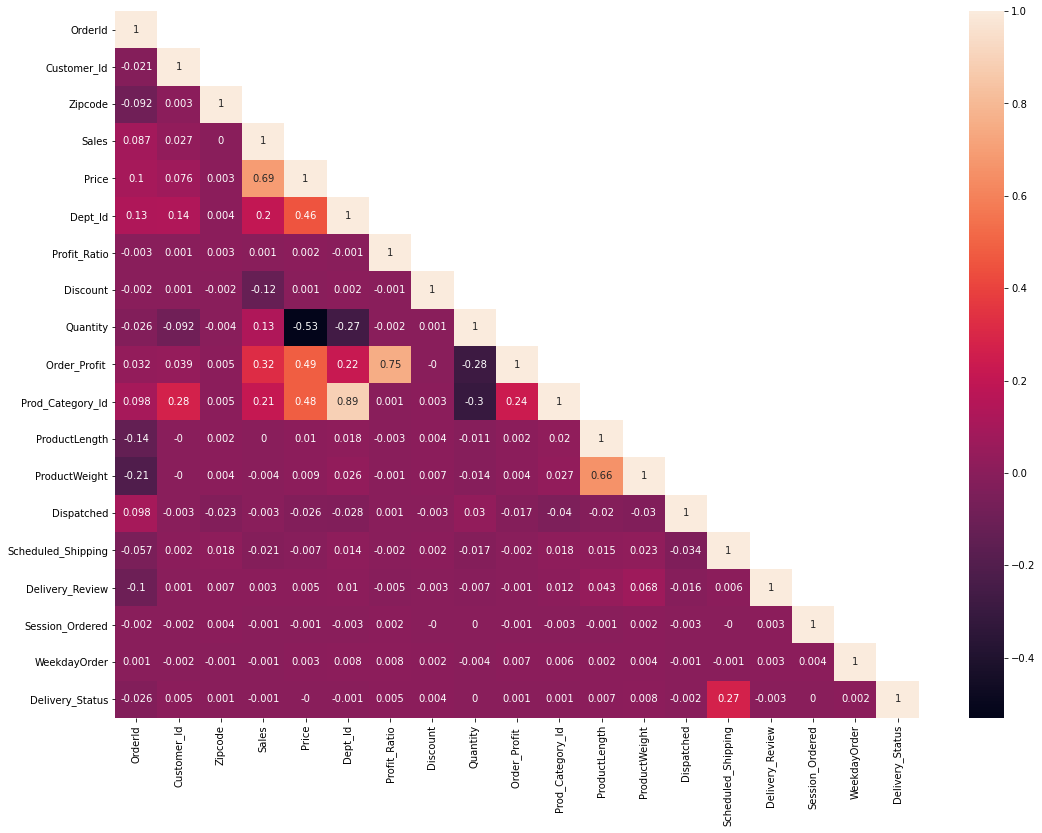

In [221]:
#Heat map - Relationalship analysis
plt.figure(figsize=(18,13))
sns.heatmap(round(df.corr(),3),annot=True,mask=np.triu(df.corr(),+1));

In [222]:
cordf = df.corr()[['Delivery_Status']].sort_values('Delivery_Status', ascending=False)
cordf[(cordf['Delivery_Status']>=0.1) | (cordf['Delivery_Status']<=-0.1)]

,Delivery_Status
Delivery_Status,1.000000
Scheduled_Shipping,0.273426


In [223]:
from sklearn.metrics import f1_score, roc_auc_score,roc_curve,accuracy_score, recall_score, confusion_matrix,classification_report, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [224]:
# from sklearn.preprocessing import LabelEncoder

# df['Product_type'] = df['Product_type'].map({'Fragile': 1, 'Not Fragile':0})

# CC_encoded = pd.get_dummies(df['Customer_Category'],prefix="CZ",drop_first=True)
# T_encoded = pd.get_dummies(df['Transcation'],prefix="T",drop_first=True)
# SC_encoded = pd.get_dummies(df['Shipping_Class'],prefix="SC",drop_first=True)
# WR_encoded = pd.get_dummies(df['Warehouse_Region'],prefix="WR",drop_first=True)
# OZ_encoded = pd.get_dummies(df['Order_zone'],prefix="OZ",drop_first=True)
# CS_encoded = pd.get_dummies(df['Cust_State'],prefix="CS",drop_first=True)
# #PT_encoded = pd.get_dummies(df['Product_type'],prefix="PT",drop_first=True)
# CT_encoded = pd.get_dummies(df['CategoryName'],prefix="PT",drop_first=True)
# df = pd.concat([df,CC_encoded,T_encoded,SC_encoded,WR_encoded,OZ_encoded,CS_encoded,PT_encoded,CT_encoded],axis=1)
# #df['CategoryName'] = df['CategoryName'].str.replace('Cat-','')

# # labelEncoder = LabelEncoder()

# # df['Cust_State_Encoded'] = labelEncoder.fit_transform(df['Cust_State'])

# validate_df = df.copy()
# df.drop(['OrderId','CategoryName','Cust_State','Customer_Id','Order_zone','Customer_Category','Cust_State','Transcation','Dept_Name','Shipping_Class','Warehouse_Region','Zipcode','Customer_Category','Transcation','Shipping_Class','Warehouse_Region','Order_zone'],axis=1,inplace=True)


In [225]:
# import dython
# from dython.nominal import associations
# x = associations(df, figsize = (40, 20))
# plt.show()

In [226]:
# from sklearn.preprocessing import LabelEncoder

# df['Product_type'] = df['Product_type'].map({'Fragile': 1, 'Not Fragile':0})

# # CC_encoded = pd.get_dummies(df['Customer_Category'],prefix="deposit_type",drop_first=True)
# # T_encoded = pd.get_dummies(df['Transcation'],prefix="deposit_type",drop_first=True)
# # SC_encoded = pd.get_dummies(df['Shipping_Class'],prefix="deposit_type",drop_first=True)
# # WR_encoded = pd.get_dummies(df['Warehouse_Region'],prefix="deposit_type",drop_first=True)
# # OZ_encoded = pd.get_dummies(df['Order_zone'],prefix="deposit_type",drop_first=True)

# # df = pd.concat([df,CC_encoded,T_encoded,SC_encoded,WR_encoded,OZ_encoded],axis=1)
# df['CategoryName'] = df['CategoryName'].str.replace('Cat-','')

# labelEncoder = LabelEncoder()

# df['Cust_State_Encoded'] = labelEncoder.fit_transform(df['Cust_State'])
# df['Customer_Category_Encoded'] = labelEncoder.fit_transform(df['Customer_Category'])
# df['Transcation_Encoded'] = labelEncoder.fit_transform(df['Transcation'])
# df['Shipping_Class_Encoded'] = labelEncoder.fit_transform(df['Shipping_Class'])
# df['Warehouse_Region_Encoded'] = labelEncoder.fit_transform(df['Warehouse_Region'])
# df['Order_zone_Encoded'] = labelEncoder.fit_transform(df['Order_zone'])


# validate_df = df.copy()
# df.drop(['Dept_Id','OrderId','Customer_Id','Order_zone','Customer_Category','Cust_State','Transcation','Dept_Name','Shipping_Class','Warehouse_Region','Zipcode','Customer_Category','Transcation','Shipping_Class','Warehouse_Region','Order_zone'],axis=1,inplace=True)

# cols = ['Dept_Id','Dispatched','Scheduled_Shipping','WeekdayOrder','CategoryName']
# for var in cols:
#     df[var] = df[var].astype('int')

In [227]:
from sklearn.preprocessing import LabelEncoder

df['Product_type'] = df['Product_type'].map({'Fragile': 1, 'Not Fragile':0})

CC_encoded = pd.get_dummies(df['Customer_Category'],prefix="deposit_type",drop_first=True)
T_encoded = pd.get_dummies(df['Transcation'],prefix="deposit_type",drop_first=True)
SC_encoded = pd.get_dummies(df['Shipping_Class'],prefix="deposit_type",drop_first=True)
WR_encoded = pd.get_dummies(df['Warehouse_Region'],prefix="deposit_type",drop_first=True)
OZ_encoded = pd.get_dummies(df['Order_zone'],prefix="deposit_type",drop_first=True)

df = pd.concat([df,CC_encoded,T_encoded,SC_encoded,WR_encoded,OZ_encoded],axis=1)
df['CategoryName'] = df['CategoryName'].str.replace('Cat-','')

labelEncoder = LabelEncoder()

df['Cust_State_Encoded'] = labelEncoder.fit_transform(df['Cust_State'])

validate_df = df.copy()
df.drop(['OrderId','Customer_Id','Order_zone','Customer_Category','Cust_State','Transcation','Dept_Name','Shipping_Class','Warehouse_Region','Zipcode'],axis=1,inplace=True)

cols = ['Dept_Id','Dispatched','Scheduled_Shipping','WeekdayOrder','CategoryName']
for var in cols:
    df[var] = df[var].astype('int')

In [228]:
df_test['Product_type'] = df_test['Product_type'].map({'Fragile': 1, 'Not Fragile':0})

CC_encoded = pd.get_dummies(df_test['Customer_Category'],prefix="deposit_type",drop_first=True)
T_encoded = pd.get_dummies(df_test['Transcation'],prefix="deposit_type",drop_first=True)
SC_encoded = pd.get_dummies(df_test['Shipping_Class'],prefix="deposit_type",drop_first=True)
WR_encoded = pd.get_dummies(df_test['Warehouse_Region'],prefix="deposit_type",drop_first=True)
OZ_encoded = pd.get_dummies(df_test['Order_zone'],prefix="deposit_type",drop_first=True)

df_test = pd.concat([df_test,CC_encoded,T_encoded,SC_encoded,WR_encoded,OZ_encoded],axis=1)
df_test['CategoryName'] = df_test['CategoryName'].str.replace('Cat-','')

labelEncoder = LabelEncoder()

df_test['Cust_State_Encoded'] = labelEncoder.fit_transform(df_test['Cust_State'])

validate_df = df_test.copy()
df_test.drop(['OrderId','Customer_Id','Order_zone','Customer_Category','Cust_State','Transcation','Dept_Name','Shipping_Class','Warehouse_Region','Zipcode'],axis=1,inplace=True)

cols = ['Dept_Id','Dispatched','Scheduled_Shipping','WeekdayOrder','CategoryName']
for var in cols:
    df_test[var] = df_test[var].astype('int')

In [229]:
df.shape

(126363, 35)

In [230]:
# ModelDf=df
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = [variance_inflation_factor(ModelDf.drop(['Delivery_Status'],axis=1).values, ix) for ix in range(ModelDf.drop(['Delivery_Status'],axis=1).shape[1])] 
# i=0
# vs = [[None for j in range(3)] for i in range(ModelDf.drop(['Delivery_Status'],axis=1).columns.shape[0])]

# for column in ModelDf.drop(['Delivery_Status'],axis=1).columns:
#         if vif[i] <= 1:
#             corrange='Not'
#         elif vif[i] >1 and vif[i] <10:
#             corrange ='Moderately'
#         else:
#             corrange ='Highly'
#         #print(f"Column {column} --> VIF : {round(vif[i],2)} and {corrange} correlated")
#         vs[i][0] = column
#         vs[i][1] = round(vif[i],2)
#         vs[i][2] = corrange
#         i=i+1
# vdf = pd.DataFrame(data=vs,columns=['Feature','Corr','CorrFactor'])

In [231]:
# vdf[vdf['CorrFactor']=='Highly']

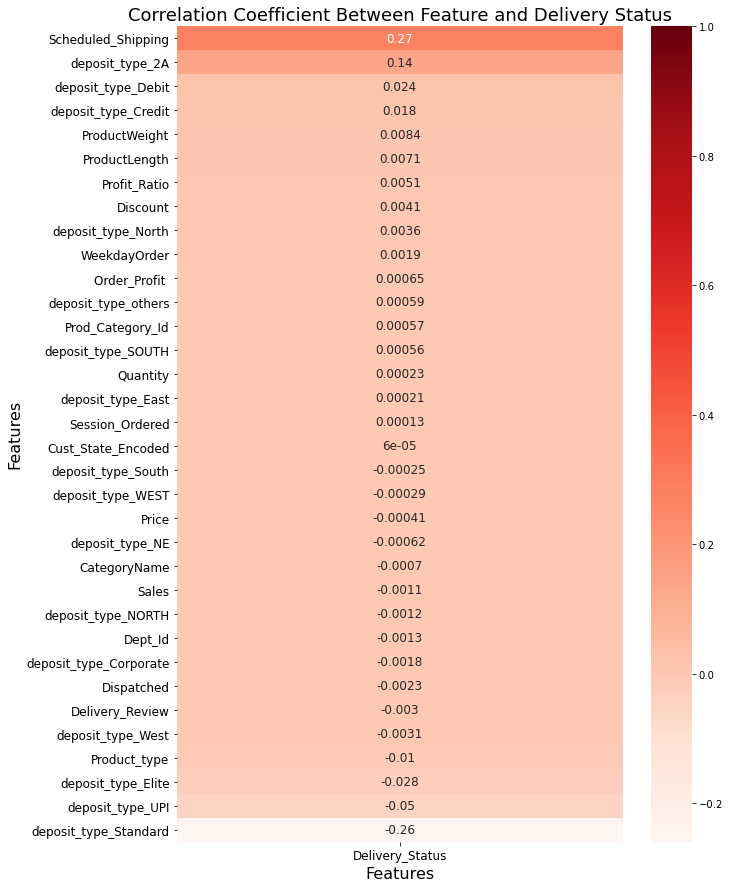

In [232]:
# Visualizing correlation coefficients between features and cancellation:
fig = plt.figure(figsize=(10,15))
ax = sns.heatmap(df.corr()[['Delivery_Status']].sort_values('Delivery_Status', ascending=False), annot = True, annot_kws = {"size":12}, cmap='Reds')
ax.set_title('Correlation Coefficient Between Feature and Delivery Status', fontsize=18)
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.tick_params(axis = "both", labelsize = 12);
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1);

In [233]:
# plt.figure(figsize=(15,10))
# sns.heatmap(ModelDf[vdf[vdf['CorrFactor']!='Highly']['Feature']].corr())

In [234]:
def display_dataframe(df):
    numeric_col_mask = df.dtypes.apply(lambda d: issubclass(np.dtype(d).type, np.number))

    # Dict used to center the table headers
    d = dict(selector="th",
        props=[('text-align', 'center')])

    # Style
    display(df.style.set_properties(subset=df.columns[numeric_col_mask], # right-align the numeric columns and set their width
                            **{'width':'5em', 'height':'3em','text-align':'right','border-color': 'white','border-style' :'solid'})\
            .set_properties(subset=df.columns[~numeric_col_mask], # left-align the non-numeric columns and set their width
                            **{'width':'5em', 'text-align':'left'})\
            .format(lambda x: '{:,.0f}'.format(x) if x > 1e3 else '{:,.2f}'.format(x), # format the numeric values
                    subset=pd.IndexSlice[:,df.columns[numeric_col_mask]])\
            .hide_index()\
#            .highlight_max('color: green')\
            .set_table_styles([d])) # center the header

In [235]:
#AUC and ROC Value
def roc_model(model_name,x,y):
    # predict probabilities
    probs = model_name.predict_proba(x)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y, probs)
    fpr, tpr, _ = roc_curve(y, probs)
    return probs,auc,fpr,tpr

In [236]:
def con_mat(y_train,y_predict_train,y_test,y_predict_test):
    fig, axis=plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(10,4)
    fig.tight_layout()

    cm=confusion_matrix(y_train,y_predict_train,labels=[0, 1])

    df_cm = pd.DataFrame(cm, index = [i for i in ["Not Delivered","Delivered"]],
    columns = [i for i in ["Not Delivered","Delivered"]])
    sns.heatmap(df_cm, annot=True ,fmt='g',ax=axis[0])
    axis[0].title.set_text('Confustion Matrix - Train Data')

    cm=confusion_matrix(y_test,y_predict_test,labels=[0, 1])

    df_cm = pd.DataFrame(cm, index = [i for i in ["Not Delivered","Delivered"]],
    columns = [i for i in ["Not Delivered","Delivered"]])
    sns.heatmap(df_cm, annot=True ,fmt='g',ax=axis[1])
    axis[1].title.set_text('Confustion Matrix - Test Data')

In [237]:
def scores_train_test(model,X_train,X_test,y_train,y_test,y_predict_train,y_predict_test,mname,model_name):
    #model=bgcl
    from IPython.display import HTML 
    from sklearn.metrics import precision_recall_fscore_support as score

    s = [[None for j in range(6)] for i in range(2)]

    print(model_name)
    print('********************************\n')

    #model_name = str(model).split('(')[0]
    s[0][0] = model_name + '_' + mname +'_Train'
    s[1][0] = model_name + '_' + mname +'_Test'
    
    report_train = classification_report(y_train, y_predict_train, output_dict=True)
    report_test = classification_report(y_test, y_predict_test, output_dict=True)

    s[0][1]=round(report_train['1']['precision']*100,2)
    s[1][1]=round(report_test['1']['precision']*100,2)

    s[0][2]=round(report_train['1']['recall']*100,2)
    s[1][2]=round(report_test['1']['recall']*100,2)

    s[0][3]=round(report_train['1']['f1-score']*100,2)
    s[1][3]=round(report_test['1']['f1-score']*100,2)

    s[0][4]=round(report_train['accuracy']*100,2)
    s[1][4]=round(report_test['accuracy']*100,2)

    probs, auc, fpr, tpr = roc_model(model,X_train,y_train)
    probst, auc1, fpr1, tpr1 = roc_model(model,X_test,y_test)

    s[0][5]=round(auc*100,2)
    s[1][5]=round(auc1*100,2)

    df = pd.DataFrame(data=s,columns=['Scores','Precision','Recall','F-Score','Accuracy','AUC'])

    con_mat(y_train,y_predict_train,y_test,y_predict_test)

    plt.figure(figsize=(5,5))

    plt.plot(fpr,tpr, marker='o', label='AUC - Train:' + str(s[0][5]))
    plt.plot(fpr1,tpr1, marker='o', label='AUC - Test:' + str(s[1][5]))

    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')

    display_dataframe(df)
    return(df)

In [238]:
def con_mat_r(y_train,y_predict_train,y_test,y_predict_test,nc,he,wi,tit):
    nc = len(y_predict_train)

    fig, axis=plt.subplots(nrows=nc,ncols=2)
    fig.set_size_inches(he,wi)
    fig.tight_layout()

    
    c=0
    for i in y_predict_train:
        cm=confusion_matrix(y_train,i,labels=[0, 1])

        df_cm = pd.DataFrame(cm, index = [i for i in ["Not Delivered","Delivered"]],
        columns = [i for i in ["Not Delivered","Delivered"]])

        sns.heatmap(df_cm, annot=True ,fmt='g',ax=axis[c][0])
        axis[c][0].title.set_text(tit[c] + ' - Train Data')
        c=c+1

    c=0
    for i in y_predict_test:
        cm=confusion_matrix(y_test,i,labels=[0, 1])

        df_cm = pd.DataFrame(cm, index = [i for i in ["Not Delivered","Delivered"]],
        columns = [i for i in ["Not Delivered","Delivered"]])

        sns.heatmap(df_cm, annot=True ,fmt='g',ax=axis[c][1])
        axis[c][1].title.set_text(tit[c] + ' - Test Data')
        c=c+1


### Split the data for training and testing

In [239]:
X = df.drop('Delivery_Status',axis=1)
y = df['Delivery_Status']

In [240]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.20,random_state=9)

In [241]:
X_train.shape

(101090, 34)

In [242]:
X_test.shape

(25273, 34)

In [243]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [244]:
sc_train = scaler.fit_transform(X_train)
sc_test = scaler.fit(X_train)
X_train_sc = pd.DataFrame(sc_train, index=X_train.index, columns=X_train.columns)

In [245]:
sc_test = psc_test = scaler.transform(X_test)
X_test_sc = pd.DataFrame(sc_test, index=X_test.index, columns=X_test.columns)

In [246]:
sc_df_test = scaler.transform(df_test)
df_test_sc = pd.DataFrame(sc_df_test, index=df_test.index, columns=df_test.columns)

In [247]:
from sklearn.tree import DecisionTreeClassifier

Decision_Tree
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
Decision_Tree_Base_Train,100.00,100.00,100.00,100.00,100.00
Decision_Tree_Base_Test,56.60,55.59,56.09,71.45,67.39


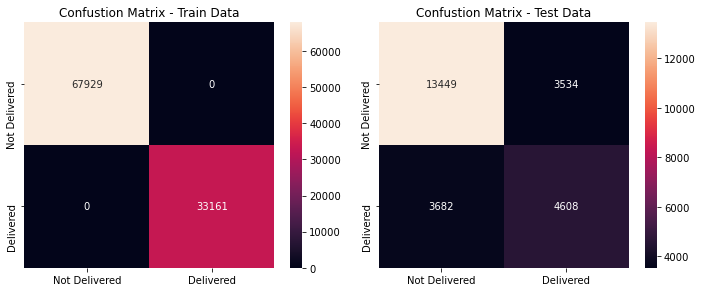

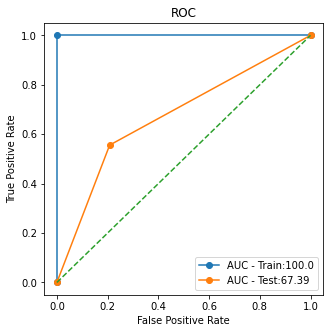

In [248]:
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train,y_train)

dtree_train_predict = dtree.predict(X_train)
dtree_test_predict = dtree.predict(X_test)

res_df = scores_train_test(dtree,X_train,X_test,y_train,y_test,dtree_train_predict,dtree_test_predict,'Base','Decision_Tree')

RandomForest
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
RandomForest_Base_Train,100.00,100.00,100.00,100.00,100.00
RandomForest_Base_Test,57.87,75.02,65.34,73.89,82.19


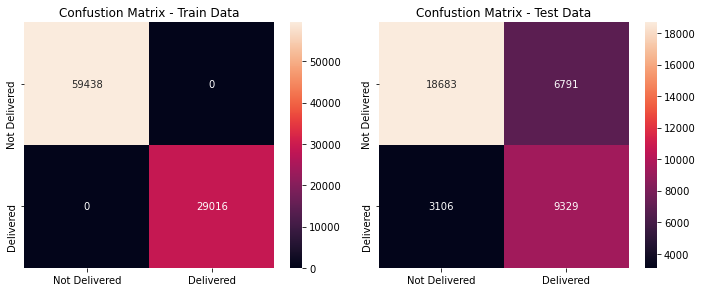

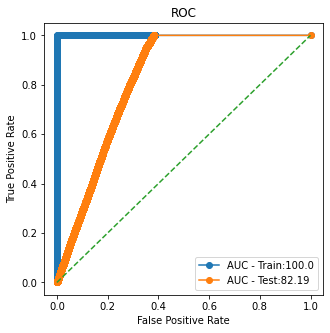

In [75]:
rfcl = RandomForestClassifier(random_state=0,max_depth=29,max_features=25,min_samples_split=3,min_samples_leaf=1)

rfcl.fit(X_train, y_train)
rf_train = rfcl.predict(X_train)
rf_test = rfcl.predict(X_test)

res_df = scores_train_test(rfcl,X_train,X_test,y_train,y_test,rf_train,rf_test,'Base','RandomForest')

RandomForest
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
RandomForest_Tuned_Train,72.70,95.23,82.46,86.71,97.30
RandomForest_Tuned_Test,58.03,81.48,67.78,74.59,82.75


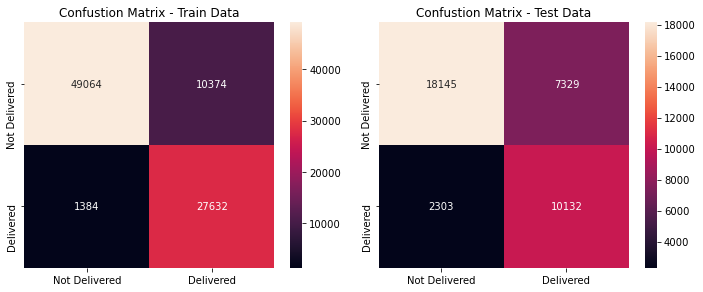

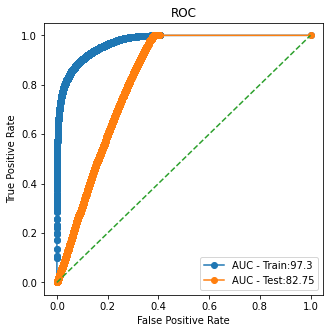

In [162]:
rfcl = RandomForestClassifier(random_state=9,max_features=21,n_estimators=175,max_depth=39,min_samples_leaf=18,min_samples_split=26)
rfcl.fit(X_train,y_train)

rfcl_y_predict_train = rfcl.predict(X_train)
rfcl_y_predict_test = rfcl.predict(X_test)

res_df = scores_train_test(rfcl,X_train,X_test,y_train,y_test,rfcl_y_predict_train,rfcl_y_predict_test,'Tuned','RandomForest')

XGBoost
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
XGBoost_Base_Train,60.20,90.78,72.39,77.29,80.74
XGBoost_Base_Test,57.30,86.54,68.95,74.43,77.53


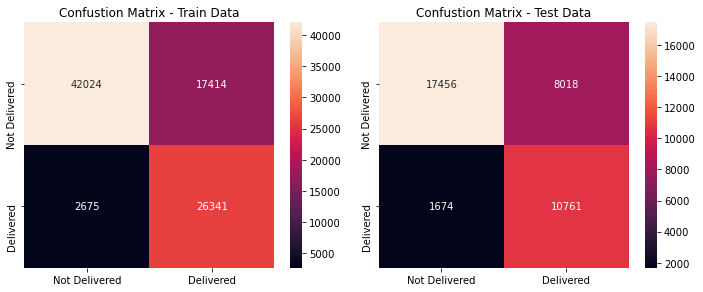

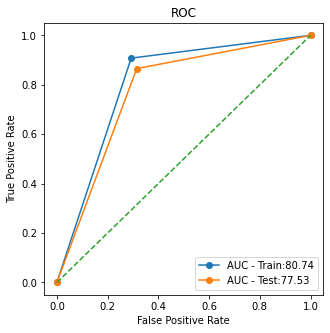

In [139]:
xgbcl = XGBClassifier(use_label_encoder=False,objective='binary:hinge')
xgbcl.fit(X_train_sc,y_train)

xgtrainpredict = xgbcl.predict(X_train_sc)
xgtestpredict = xgbcl.predict(X_test_sc)

res_df=scores_train_test(xgbcl,X_train_sc,X_test_sc,y_train,y_test,xgtrainpredict,xgtestpredict,'Base','XGBoost')

XGBoost
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
XGBoost_Tuned_Train,59.62,92.35,72.46,76.97,80.91
XGBoost_Tuned_Test,56.87,88.30,69.18,74.19,77.80


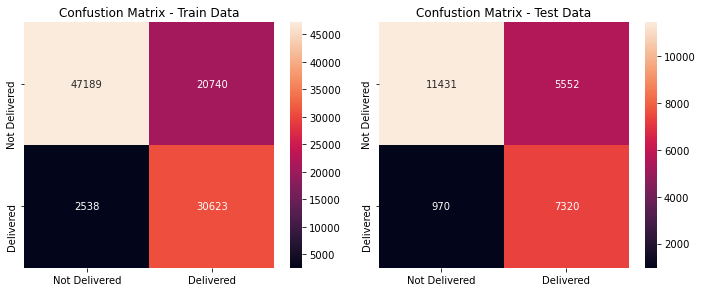

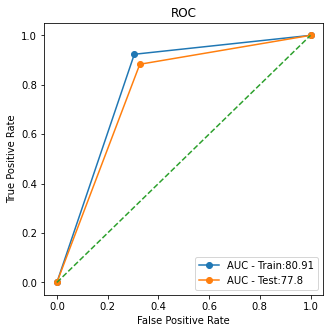

In [249]:
xgbcl = XGBClassifier(use_label_encoder=False)
param_grid = {
     'objective':['binary:hinge']
}
xgbcl = GridSearchCV(xgbcl, 
                    param_grid = param_grid, 
                    scoring = "f1", 
                    cv = 3)
xgbcl.fit(X_train_sc,y_train)
xgbcl.best_estimator_
# Dictionary of best parameters

xgtrainpredict = xgbcl.predict(X_train_sc)
xgtestpredict = xgbcl.predict(X_test_sc)

res_df=scores_train_test(xgbcl,X_train_sc,X_test_sc,y_train,y_test,xgtrainpredict,xgtestpredict,'Tuned','XGBoost')

In [156]:
from sklearn.ensemble import BaggingClassifier
bgcl = BaggingClassifier(base_estimator=rfcl, n_estimators=50,random_state=0)

bgcl = bgcl.fit(X_train, y_train)

bgcl_y_predict_train = bgcl.predict(X_train)
bgcl_y_predict_test = bgcl.predict(X_test)

BaggingClassifier
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
BaggingClassifier_Bagging_Train,70.53,95.50,81.14,85.44,65.30
BaggingClassifier_Bagging_Test,57.91,82.13,67.93,74.56,65.84


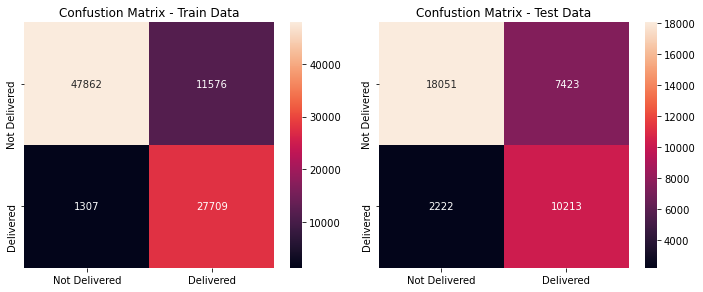

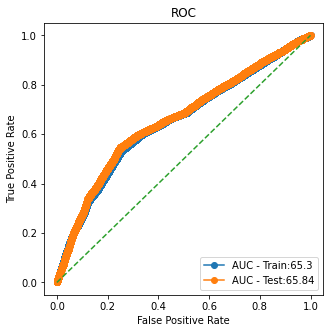

In [157]:
res_df = scores_train_test(bgcl,X_train_sc,X_test_sc,y_train,y_test,bgcl_y_predict_train,bgcl_y_predict_test,'Bagging','BaggingClassifier')

In [250]:
final_model = xgbcl.fit(X,y)

In [251]:
rf_output = final_model.predict(df_test)

In [252]:
rf_output

array([1, 0, 1, ..., 1, 1, 1])

In [253]:
df_test_sc["Delivery_Status"]= rf_output

In [254]:
df_test_sc['OrderId']=validate_df['OrderId']

In [255]:
m='base'

In [256]:
df_test_sc[['OrderId','Delivery_Status']].to_csv('./Hack_submission_'+m+'.csv',index=False)